# Quickstart Example with Synthetic RTB Simulation and Dataset (Data Collection)
This notebook provides an example of visualizing the logged dataset collected on an RTB environment.

This example on consists of the following 3 cases:
1. Discrete Action Case
2. Continuous Action Case
3. Collecting Logged Datasets with Multiple Behavior Policies and Random Seeds

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations.  
\* Also, our data collection module is highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [2]:
# delete later
%load_ext autoreload
%autoreload 2

In [3]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [4]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [5]:
# import OFRL modules
import ofrl
from rtbgym import RTBEnv, CustomizedRTBEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy
from d3rlpy.algos import RandomPolicy as ContinuousRandomPolicy
from d3rlpy.preprocessing import MinMaxActionScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

In [6]:
import pickle
from dataclasses import dataclass
from typing import Tuple, Union, Optional
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [7]:
# version
print(ofrl.__version__)

0.0.0


In [8]:
# set random state
random_state = 12345
random_ = check_random_state(random_state)

## 0. Description of Synthetic RTB Simulation Environment
To begin with, we briefly describe the basic usage of the environment.

#### RL setup for RTB
In RTB, the objective of the RL agent is to maximize some KPIs (number of clicks or conversions) within an episode under given budget constraints.  

We often try to achieve this by adjusting bidding price function parameter $\alpha$. By using $\alpha$, we can adjust the bid price as follows.  
$bid_{t,i} = \alpha \cdot r^{\ast}$, 
where $r^{\ast}$ denotes a predicted or expected reward (KPIs).

We often formulate this RTB problem as the following Constrained Markov Decision Process (CMDP):
- `timestep`: One episode (a day or a week) consists of several timesteps (24 hours or seven days, for instance).
- `state`: We observe some feedback from the environment at each timestep, which includes the following.
  - timestep
  - remaining budget
  - impression level features (budget consumption rate, cost per mille of impressions, auction winning rate, reward) at the previous timestep
  - adjust rate (RL agent's decision making) at the previous timestep
- `action`: Agent chooses adjust rate parameter $\alpha$ to maximize KPIs.
- `reward`: Total number of clicks or conversions obtained during the timestep.
- `constraints`: The pre-determined episodic budget should not be exceeded.

Let's see how it works!

In [9]:
# setup environment
env = RTBEnv(random_state=random_state)

In [10]:
# define a random agent
agent = OnlineHead(
    ContinuousRandomPolicy(
        action_scaler=MinMaxActionScaler(
            minimum=0.1,  # minimum value that policy can take
            maximum=10,  # maximum value that policy can take
        )
    ),
    name="random",
)

In [11]:
# interact agent with the environment
# only 6 lines are needed for RL interaction
for episode in range(10):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, truncated, info = env.step(action)

In [12]:
# state consists of the following feedback from the environment
print(env.obs_keys)
print(obs.shape)

['timestep', 'remaining_budget', 'budget_consumption_rate', 'cost_per_mille_of_impression', 'winning_rate', 'reward', 'adjust_rate']
(7,)


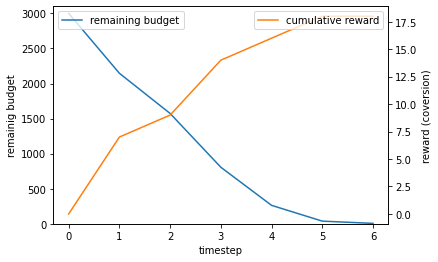

In [13]:
# let's visualize the transition of the remaining budget and cumulative reward
# our goal is to obtain a policy (or an agent) that maximizes the cumulative reward under budget constraints using RL.  
# for more visualization, please see the appendix.
obs, info = env.reset()
done = False
remaining_budget = [obs[1]]
cumulative_reward = [0]

while not done:
    action = agent.predict_online(obs)
    obs, reward, done, truncated, info = env.step(action)
    remaining_budget.append(obs[1])
    cumulative_reward.append(cumulative_reward[-1] + reward)

# plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(remaining_budget[:-1], label='remaining budget')
ax2 = ax1.twinx()
ax2.plot(cumulative_reward[:-1], label='cumulative reward', color='tab:orange')
ax1.set_xlabel('timestep')
ax1.set_ylabel('remainig budget')
ax1.set_ylim(0, env.initial_budget + 100)
ax2.set_ylabel('reward (coversion)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

For more about the environmental configuration , please refer to [examples/quickstart/rtb_synthetic_customize_env.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_customize_env.ipynb).

## 1. Discrete Action Case
Here, we present how to collect logged data by a behavior policy in the case of discrete action.

The procedure requires two steps:

1. Learn a base deterministic policy
2. Convert the deterministic policy into a stochastic policy.

Below, we first learn a deterministic policy using [d3rlpy](https://github.com/takuseno/d3rlpy).

In [14]:
# standardized environment for discrete action
env = gym.make("RTBEnv-discrete-v0")

In [15]:
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

In [16]:
# learn a base deterministic policy for data collection
from d3rlpy.algos import DoubleDQN
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy

# model
ddqn = DoubleDQN(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
    use_gpu=torch.cuda.is_available(),
)
# replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)
# explorers
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=1000,
)

In [16]:
# start training
# skip if there is a pre-trained model
ddqn.fit_online(
    env_,
    buffer,
    explorer=explorer,
    eval_env=env_,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

2023-01-25 22:50.05 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20230125225005
2023-01-25 22:50.05 [debug    ] Building model...
2023-01-25 22:50.05 [debug    ] Model has been built.
2023-01-25 22:50.05 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20230125225005/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DoubleDQN', 'observation_shape': (7,), 'action_s

  0%|          | 0/100000 [00:00<?, ?it/s]

2023-01-25 22:50.06 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230125225005/model_1000.pt
2023-01-25 22:50.06 [info     ] DoubleDQN_online_20230125225005: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.0002795069217681885, 'time_environment_step': 0.0005443143844604492, 'time_step': 0.0008589260578155518, 'rollout_return': 14.112676056338028, 'evaluation': 15.7} step=1000
2023-01-25 22:50.08 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230125225005/model_2000.pt
2023-01-25 22:50.08 [info     ] DoubleDQN_online_20230125225005: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.0003136880397796631, 'time_environment_step': 0.0006423537731170654, 'time_sample_batch': 7.979321479797364e-05, 'time_algorithm_update': 0.0012409803867340088, 'loss': 74.5771382484436, 'time_step': 0.002334807872772217, 'rollout_return': 10.47887323943662, 'evaluation': 0.0} step=2000
2023-01-25 22:50.11 [info     ] Model parameters are saved 

In [17]:
# save model
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [17]:
# reload model
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

### 1.1. Epsilon-Greedy behavior policy

Let's now convert the deterministic policy (i.e., ddqn policy) into a stochastic behavior policy.

We use epsilon-greedy policy to collect logged data using `DiscreteEpsilonGreedyHead`, where the behavior policy greedily takes an action chosen by the deterministic policy with probability $1 - \epsilon$ and takes an action randomly with probability $\epsilon$ as follows.

$$\pi(a | s) := (1 - \epsilon) * \pi_{\mathrm{det}}(a | s) + \epsilon / |\mathcal{A}|,$$

where $a \in \mathcal{A}$ is an action, $s \in \mathcal{S}$ is a state, and $\pi$ is a stochastic policy defined with the (deterministic) behavior policy $\pi_{\mathrm{det}}$.

Note that, `SyntheticDataset` has the following arguments:
- `env`: RTB environment for RL defined in the previous section.
- `behavior_policy`: RL agent (or algorithm) used for the data collection.
- `maximum_step_per_episode`: Maximum number of timesteps in an episode.
- `action_meaning`: Dictionary which maps discrete action index into specific actions.
- `action_keys`: Name of the action variable at each dimension.
- `state_keys`: Name of the state variable at each dimension.
- `info_keys`: Dictionary containing of key and the type of info components.
- `random_state`: Random state.

In [18]:
# convert the base ddqn policy into a stochastic data collection policy
from ofrl.policy import DiscreteEpsilonGreedyHead

behavior_policy = DiscreteEpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,  # probability of taking random action
    name="ddqn_epsilon_0.3",
    random_state=random_state,
)

In [20]:
# collect data
dataset = SyntheticDataset(
    env=env,
    action_meaning=env.action_meaning,
    state_keys=env.obs_keys,
    max_episode_steps=env.step_per_episode,
    info_keys={
        "search_volume": int,
        "impression": int,
        "click": int,
        "conversion": int,
        "average_bid_price": float,
    },
)
logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state,
)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [21]:
logged_dataset

{'size': 70000,
 'n_trajectories': 10000,
 'step_per_trajectory': 7,
 'action_type': 'discrete',
 'n_actions': 10,
 'action_dim': None,
 'action_meaning': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
         1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
 'action_keys': None,
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 8.26436129e-01, ...,
         9.56309981e-01, 1.00000000e+00, 1.69684257e+00],
        [1.00000000e+00, 1.91000000e+03, 3.63333333e-01, ...,
         1.00000000e+00, 6.00000000e+00, 3.59381366e+00],
        [2.00000000e+00, 1.91000000e+03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.66810054e-01],
        ...,
        [4.00000000e+00, 1.60000000e+01, 9.83228512e-01, ...,
         8.64734300e-01, 4.00000000e+00, 5.99484250e+0

In [22]:
# let's see some statistics of the dataset
# we see that the environment is highly stochastic and the reward is sparse
df = pd.DataFrame()
df['adjust rate'] = logged_dataset['state'][:, 6]
df['average bid price'] = logged_dataset['info']['average_bid_price']
df['impression'] = logged_dataset['info']['impression']
df['click'] = logged_dataset['info']['click']
df['conversion'] = logged_dataset['info']['conversion']
df['winning rate'] = logged_dataset['state'][:, 4]
df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
df.describe()

,adjust rate,average bid price,impression,click,conversion,winning rate,click / impression,conversion / click
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,1.814493,97.202044,83.975814,8.712529,2.153000,0.473776,0.061698,0.130698
std,2.189575,116.477408,87.502824,9.633398,2.977986,0.422109,0.071538,0.173837
min,0.000052,3.994444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.229959,8.343874,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.291550,66.426031,38.000000,3.000000,0.000000,0.467234,0.068965,0.000000
75%,2.154435,105.869867,175.000000,18.000000,4.000000,0.896763,0.108247,0.235294
max,10.000000,550.077778,290.000000,41.000000,20.000000,1.000000,0.999995,0.999998


In [23]:
# aggregate episodic statistics
df_ = pd.DataFrame()
df_['average adjust rate'] = logged_dataset['state'][:, 6].reshape(-1, 7).mean(axis=1)
df_['average bid price'] = logged_dataset['info']['average_bid_price'].reshape(-1, 7).mean(axis=1)
df_['total impression'] = logged_dataset['info']['impression'].reshape(-1, 7).mean(axis=1)
df_['total click'] = logged_dataset['info']['click'].reshape(-1, 7).mean(axis=1)
df_['total conversion'] = logged_dataset['info']['conversion'].reshape(-1, 7).mean(axis=1)
df_['remaining budget'] = logged_dataset['state'][:,1].reshape(-1, 7)[:,6]
df_.describe()

,average adjust rate,average bid price,total impression,total click,total conversion,remaining budget
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,1.814493,97.202044,83.975814,8.712529,2.153000,177.71290
std,0.763669,40.940626,10.299945,0.723192,0.562344,375.20084
min,0.368193,16.966220,21.857143,1.285714,0.142857,1.00000
25%,1.231567,65.634993,77.714286,8.571429,1.714286,13.00000
50%,1.655142,87.972114,83.857143,8.857143,2.142857,27.00000
75%,2.316696,123.187874,90.285714,9.142857,2.571429,58.00000
max,6.603720,329.810583,124.285714,10.714286,4.857143,2874.00000


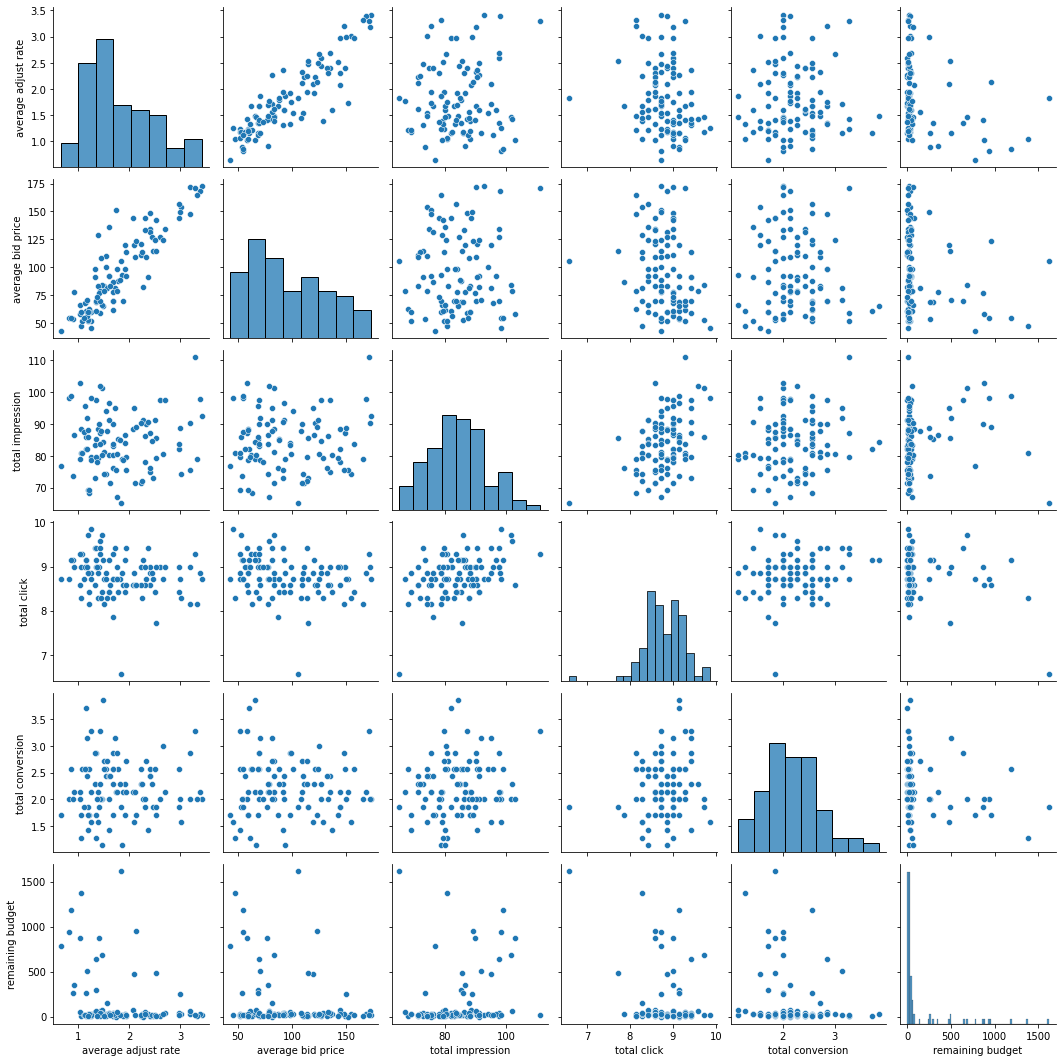

In [24]:
# we see a strong correlation between number of impression and click.
# However, large number of click does not necessarily lead to conversion.
sns.pairplot(df_[:100])

### 1.2. Softmax behavior policy
We can also use `DiscreteSoftmaxHead` to derive a stochastic behavior policy.

This algorithm uses Q function of the original algorithm, which estimates the value of a given context and action pair (i.e., $(s, a)$) as $Q(s, a)$. \
Specifically, the behavior policy chooses actions stochastically as:

$$\pi(a \mid s) = \frac{\exp(Q(s, a) / \tau)}{\sum_{a' \in A} \exp(Q(s, a') / \tau)},$$

where $A$ indicates the set discrete actions and $\tau$ is an inverse temperature parameter.

In [25]:
# convert base ddqn policy into a stochastic data collection policy
from ofrl.policy import DiscreteSoftmaxHead

behavior_policy = DiscreteSoftmaxHead(
    ddqn, 
    n_actions=env.action_space.n,
    tau=1.0,  # temperature parameter
    name="ddqn_softmax_tau_1.0",
    random_state=random_state,
)

In [26]:
# collect data
dataset = SyntheticDataset(
    env=env,
    action_meaning=env.action_meaning,
    state_keys=env.obs_keys,
    max_episode_steps=env.step_per_episode,
    info_keys={
        "search_volume": int,
        "impression": int,
        "click": int,
        "conversion": int,
        "average_bid_price": float,
    },
)
logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy, 
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state,
)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [27]:
logged_dataset

{'size': 70000,
 'n_trajectories': 10000,
 'step_per_trajectory': 7,
 'action_type': 'discrete',
 'n_actions': 10,
 'action_dim': None,
 'action_meaning': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
         1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
 'action_keys': None,
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 8.26436129e-01, ...,
         9.56309981e-01, 1.00000000e+00, 1.90571752e+00],
        [1.00000000e+00, 1.91000000e+03, 3.63333333e-01, ...,
         1.00000000e+00, 6.00000000e+00, 3.59381366e+00],
        [2.00000000e+00, 1.91000000e+03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.66810054e-01],
        ...,
        [4.00000000e+00, 2.22000000e+02, 8.31435080e-01, ...,
         1.00000000e+00, 4.00000000e+00, 5.99484250e+0

In [28]:
# let's see some statistics of the dataset
# we see that the environment is highly stochastic and the reward is sparse
df = pd.DataFrame()
df['adjust rate'] = logged_dataset['state'][:, 6]
df['average bid price'] = logged_dataset['info']['average_bid_price']
df['impression'] = logged_dataset['info']['impression']
df['click'] = logged_dataset['info']['click']
df['conversion'] = logged_dataset['info']['conversion']
df['winning rate'] = logged_dataset['state'][:, 4]
df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
df.describe()

,adjust rate,average bid price,impression,click,conversion,winning rate,click / impression,conversion / click
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,2.138157,115.906061,80.080343,8.217586,1.971471,0.445346,0.063712,0.126916
std,2.761207,146.360324,87.450527,9.462834,2.858342,0.423780,0.080687,0.175897
min,0.000129,3.995690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.278256,13.479112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.997088,61.248643,36.000000,3.000000,0.000000,0.296117,0.066667,0.000000
75%,2.154435,170.315458,176.000000,17.000000,3.000000,0.947025,0.107527,0.227273
max,10.048312,553.283582,290.000000,41.000000,20.000000,1.000000,0.999995,0.999998


In [29]:
# aggregate episodic statistics
df_ = pd.DataFrame()
df_['average adjust rate'] = logged_dataset['state'][:, 6].reshape(-1, 7).mean(axis=1)
df_['average bid price'] = logged_dataset['info']['average_bid_price'].reshape(-1, 7).mean(axis=1)
df_['total impression'] = logged_dataset['info']['impression'].reshape(-1, 7).mean(axis=1)
df_['total click'] = logged_dataset['info']['click'].reshape(-1, 7).mean(axis=1)
df_['total conversion'] = logged_dataset['info']['conversion'].reshape(-1, 7).mean(axis=1)
df_['remaining budget'] = logged_dataset['state'][:,1].reshape(-1, 7)[:,6]
df_.describe()

,average adjust rate,average bid price,total impression,total click,total conversion,remaining budget
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.138157,115.906061,80.080343,8.217586,1.971471,416.116700
std,0.964726,51.865666,15.110467,1.371115,0.617515,608.131427
min,0.235633,10.560999,0.000000,0.000000,0.000000,1.000000
25%,1.389578,76.722946,73.000000,8.142857,1.571429,18.000000
50%,2.051008,110.607900,82.000000,8.571429,2.000000,43.000000
75%,2.754484,148.883434,89.428571,9.000000,2.428571,708.250000
max,7.281634,421.159404,127.000000,10.714286,4.142857,3000.000000


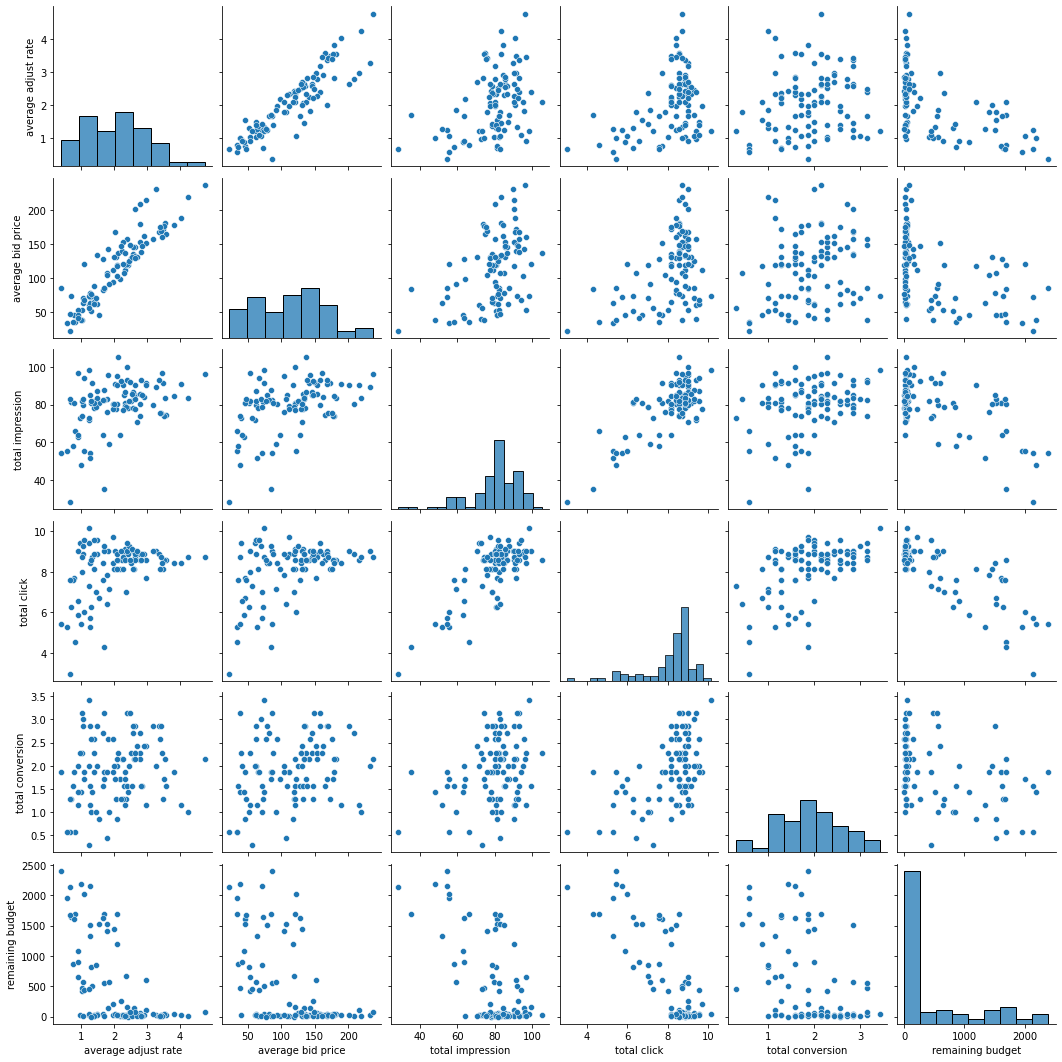

In [30]:
# seems softmax policy obtain impression more, but conversion less than the epsilon-greedy policy
sns.pairplot(df_[:100])

For offline RL and OPE procedures, please refer to [examples/quickstart/rtb_synthetic_discrete_basic.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/master/examples/quickstart/rtb_synthetic_discrete_basic.ipynb).

For more advanced topic in OPE and OPS, please refer to [examples/quickstart/rtb_synthetic_discrete_advanced.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_discrete_advanced.ipynb).

## 2. Continuous Action Space
We also describe the case where a continuous behavior policy is used. \
Here, we first learn a base deterministic policy in a similar manner with the discrete action case.

In [31]:
# standardized environment for continuous action
env = gym.make("RTBEnv-continuous-v0")

In [32]:
# for api compatibility to d3rlpy
env_ = OldGymAPIWrapper(env)

In [33]:
# learn base deterministic policy for data collection
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

# model
sac = SAC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,   # 0.1
        maximum=env.action_space.high,  # 10
    ),
)
# setup replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env,
)

In [34]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env_,
    buffer,
    eval_env=env_,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

2022-11-23 16:44.36 [info     ] Directory is created at d3rlpy_logs/SAC_online_20221123164436
2022-11-23 16:44.36 [debug    ] Fitting action scaler...       action_scler=min_max
2022-11-23 16:44.36 [debug    ] Building model...
2022-11-23 16:44.36 [debug    ] Model has been built.
2022-11-23 16:44.36 [info     ] Parameters are saved to d3rlpy_logs/SAC_online_20221123164436/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense'

  0%|          | 0/100000 [00:00<?, ?it/s]

2022-11-23 16:44.39 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20221123164436/model_1000.pt
2022-11-23 16:44.39 [info     ] SAC_online_20221123164436: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.0013994889259338378, 'time_environment_step': 0.0014064352512359619, 'time_step': 0.0028970425128936766, 'rollout_return': 0.0, 'evaluation': 0.0} step=1000
2022-11-23 16:44.58 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20221123164436/model_2000.pt
2022-11-23 16:44.58 [info     ] SAC_online_20221123164436: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.0011525535583496093, 'time_environment_step': 0.001337526798248291, 'time_sample_batch': 0.0004522709846496582, 'time_algorithm_update': 0.01590130662918091, 'temp_loss': -3.45796284157224, 'temp': 1.0742649326324463, 'critic_loss': 1951.2604142761231, 'actor_loss': 47.786249404907224, 'time_step': 0.018961639642715453, 'rollout_return': 13.598591549295774, 'evaluation': 15.9} step=20

In [ ]:
# save model
sac.save_model("d3rlpy_logs/sac.pt")

In [34]:
# reload model
sac.build_with_env(env)
sac.load_model("d3rlpy_logs/sac.pt")

### 2.1. Gaussian behavior policy

Then, we convert a deterministic policy (i.e., greedy action choice of sac policy) into a stochastic policy. 

As the action space of `RTBEnv` is bounded, we use `ContinuousTruncatedGaussianHead`. \
Given the deterministic action $\pi(s)$, this behavior policy samples actions from a truncated gaussian distribution as:

$$a \sim Truncnorm(\pi(s), \sigma),$$

where $\sigma$ indicates the noise level. 

Note that, when action space is not bounded, we can use `ContinuousGaussianHead` in a similar manner.

In [35]:
# convert base ddqn policy into a stochastic data collection policy
from ofrl.policy import ContinuousTruncatedGaussianHead

behavior_policy = ContinuousTruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,  # lower bound of the action space
    maximum=env.action_space.high,  # upper bound of the action space
    sigma=np.array([1.0]),  # noise level of a gaussian distribution
    name="sac_sigma_1.0",
    random_state=random_state,
)

In [36]:
# collect data
dataset = SyntheticDataset(
    env=env,
    state_keys=env.obs_keys,
    max_episode_steps=env.step_per_episode,
    info_keys={
        "search_volume": int,
        "impression": int,
        "click": int,
        "conversion": int,
        "average_bid_price": float,
    },
)
logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state,
)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [37]:
logged_dataset

{'size': 70000,
 'n_trajectories': 10000,
 'step_per_trajectory': 7,
 'action_type': 'continuous',
 'n_actions': None,
 'action_dim': 1,
 'action_meaning': None,
 'action_keys': None,
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 8.26436129e-01, ...,
         9.56309981e-01, 1.00000000e+00, 8.75252893e-02],
        [1.00000000e+00, 1.91000000e+03, 3.63333333e-01, ...,
         1.00000000e+00, 6.00000000e+00, 8.88088936e+00],
        [2.00000000e+00, 1.17300000e+03, 3.85863874e-01, ...,
         1.00000000e+00, 1.00000000e+00, 2.28582109e+00],
        ...,
        [4.00000000e+00, 2.93000000e+02, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.64273473e-01],
        [5.00000000e+00, 2.10000000e+01, 9.28327645e-01, ...,
         1.33004926e-01, 1.00000000e+00, 9.93383284e+00],
        [6.00000

In [38]:
# let's see some statistics of the dataset
# we see that the environment is highly stochastic and the reward is sparse, similarly to the discrete case
df = pd.DataFrame()
df['adjust rate'] = logged_dataset['state'][:, 6]
df['average bid price'] = logged_dataset['info']['average_bid_price']
df['impression'] = logged_dataset['info']['impression']
df['click'] = logged_dataset['info']['click']
df['conversion'] = logged_dataset['info']['conversion']
df['winning rate'] = logged_dataset['state'][:, 4]
df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
df.describe()

,adjust rate,average bid price,impression,click,conversion,winning rate,click / impression,conversion / click
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,3.213935,177.791641,89.176900,8.916800,2.232771,0.505694,0.072786,0.150702
std,3.513194,186.344255,84.744413,9.146443,3.053496,0.405506,0.075591,0.189663
min,0.000068,3.994253,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.659046,38.861397,5.000000,0.000000,0.000000,0.062176,0.000000,0.000000
50%,1.409655,79.255945,61.000000,6.000000,1.000000,0.494382,0.081967,0.083333
75%,7.502108,393.123940,180.000000,17.000000,4.000000,0.995050,0.111111,0.260869
max,11.125847,563.946860,290.000000,41.000000,20.000000,1.000000,0.999995,0.999998


In [39]:
# aggregate episodic statistics
# compared to the discrete case, remaining budget is small, meaning that the continuous case is more flexible
df_ = pd.DataFrame()
df_['average adjust rate'] = logged_dataset['state'][:, 6].reshape(-1, 7).mean(axis=1)
df_['average bid price'] = logged_dataset['info']['average_bid_price'].reshape(-1, 7).mean(axis=1)
df_['total impression'] = logged_dataset['info']['impression'].reshape(-1, 7).mean(axis=1)
df_['total click'] = logged_dataset['info']['click'].reshape(-1, 7).mean(axis=1)
df_['total conversion'] = logged_dataset['info']['conversion'].reshape(-1, 7).mean(axis=1)
df_['remaining budget'] = logged_dataset['state'][:,1].reshape(-1, 7)[:,6]
df_.describe()

,average adjust rate,average bid price,total impression,total click,total conversion,remaining budget
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,3.213935,177.791641,89.176900,8.916800,2.232771,90.69190
std,0.677234,35.540313,10.511529,0.528529,0.507895,210.40087
min,1.465719,85.949870,38.000000,4.142857,0.714286,1.00000
25%,2.731889,155.150791,82.000000,8.571429,1.857143,11.00000
50%,3.217945,175.658698,89.000000,8.857143,2.285714,22.00000
75%,3.616271,205.893406,96.000000,9.285714,2.571429,39.00000
max,5.383163,293.146544,131.142857,10.857143,4.285714,2108.00000


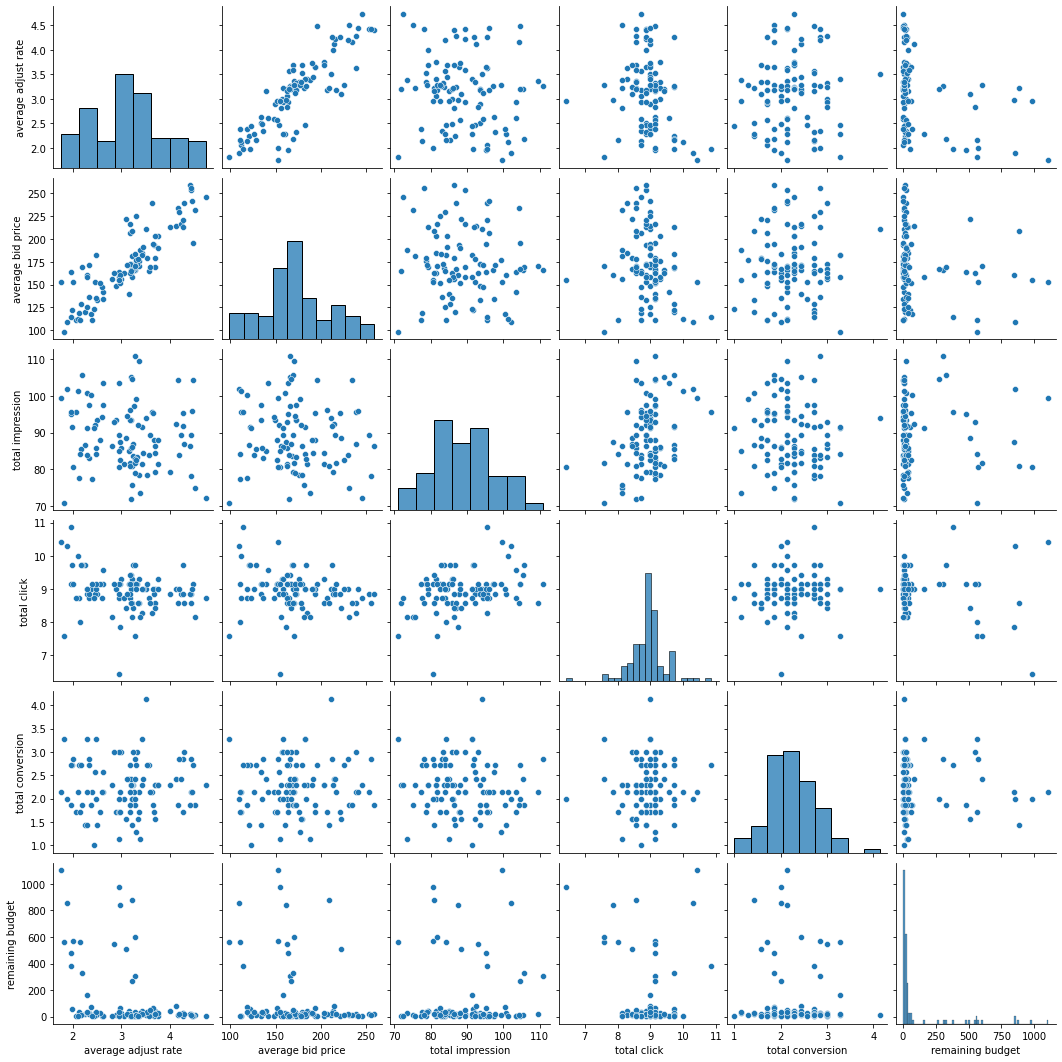

In [40]:
# the result reveals that there is slight negative correlation between bid price and impression
sns.pairplot(df_[:100])

## 3. Collecting Logged Datasets with Multiple Behavior Policies and Random Seeds
Finally, we show how to collect logged data by several behavior policies and random seeds.

We show the example in the discrete action case, but the continuous action case can also be handled in a simmilar manner.

In [19]:
# define several behavior policies
behavior_policy_01 = DiscreteEpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.1,  # probability of taking random action
    name="ddqn_eps_0.1",
    random_state=random_state,
)
behavior_policy_03 = DiscreteEpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,  # probability of taking random action
    name="ddqn_eps_0.3",
    random_state=random_state,
)
behavior_policy_05 = DiscreteEpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.5,  # probability of taking random action
    name="ddqn_eps_0.5",
    random_state=random_state,
)
behavior_policy_07 = DiscreteEpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.7,  # probability of taking random action
    name="ddqn_eps_0.7",
    random_state=random_state,
)
behavior_policies = [behavior_policy_01, behavior_policy_03, behavior_policy_05, behavior_policy_07]

In [20]:
# initialize the dataset class
dataset = SyntheticDataset(
    env=env,
    action_meaning=env.action_meaning,
    state_keys=env.obs_keys,
    max_episode_steps=env.step_per_episode,
    info_keys={
        "search_volume": int,
        "impression": int,
        "click": int,
        "conversion": int,
        "average_bid_price": float,
    },
)

In [21]:
logged_datasets = dataset.obtain_episodes(
    behavior_policies=behavior_policies,
    n_datasets=5,  # number of random states
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state,
)

[obtain_datasets: behavior_policy]:   0%|          | 0/4 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/5 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/5 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/5 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/5 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [22]:
logged_dataset = logged_datasets.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)
logged_dataset

{'size': 70000,
 'n_trajectories': 10000,
 'step_per_trajectory': 7,
 'action_type': 'discrete',
 'n_actions': 10,
 'action_dim': None,
 'action_meaning': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
         1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
 'action_keys': None,
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 8.26436129e-01, ...,
         9.56309981e-01, 1.00000000e+00, 1.07760844e+00],
        [1.00000000e+00, 1.91000000e+03, 3.63333333e-01, ...,
         1.00000000e+00, 6.00000000e+00, 5.99484250e+00],
        [2.00000000e+00, 1.91000000e+03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.00000000e-01],
        ...,
        [4.00000000e+00, 6.81000000e+02, 6.16554054e-01, ...,
         1.00000000e+00, 4.00000000e+00, 5.99484250e+0

For offline RL and OPE procedures, please refer to [examples/quickstart/rtb_synthetic_continuous_basic.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_continuous_basic.ipynb). 

For advanced topics regarding OPE and OPS, please refer to [examples/quickstart/rtb_synthetic_continuous_advanced.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_continuous_advanced.ipynb).

## Reference

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Tuomas Haarnoja, Aurick Zhou, Pieter Abbeel, and Sergey Levine. \
"Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor." 2018.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.